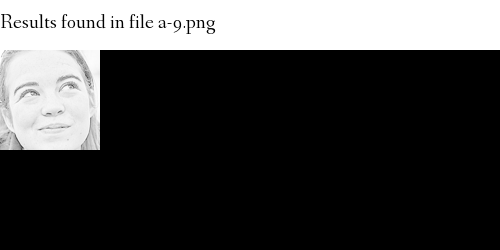

In [4]:
import zipfile
import io
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"#running personal copy of jupyter and tesseract


# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')


# the rest is up to you!


#### term to search ####
search_str='MARK'


### images as PIL images and arrays
imgzip = zipfile.ZipFile('readonly/images.zip')
inflist = imgzip.infolist()
img_list=[]
img_list_facedet=[]
file_name=[]
for f in inflist:
    ifile = imgzip.open(f)
    img = Image.open(ifile)
    img_list.append(img)
    img_fd=np.asarray(img, dtype = 'uint8')
    img_list_facedet.append(img_fd)
    file_name.append(f.filename)
    #print(f.filename)
    #display(img)
#img_list


### text in images


text_list = []
for pic in img_list:
    pic=pic.convert('L')
    text = pytesseract.image_to_string(pic)
    text_list.append(text)
    
#search text and store results
search_res = []
for article in text_list:
    if search_str in article:
        search_res.append(True)
    else:
        search_res.append(False)
        
#cropping faces from the newspaper
#scalefactor 1.3
cropped_faces = []
info_sheets = []
i = 0
for pic in img_list_facedet:  
    #face detection
    faces = face_cascade.detectMultiScale(pic, scaleFactor = 1.3)
    tuples = [(x, y, x + w, y + h) for x, y, w, h in faces]
    img = Image.fromarray(pic)
    #contact sheet creation
    img_w=100
    img_h=100
    contact_sheet = Image.new(img.mode, (img_w * 5, img_h * 2))
    #face cropping and contact sheet pasting
    x = 0
    y = 0
    num_cropped = 0
    for t in tuples:
        cropped = img.crop(t)        
        cropped = cropped.resize((img_w, img_h))
        cropped_faces.append(cropped)
        contact_sheet.paste(cropped, (x, y))
        if x + img_h == contact_sheet.width:
            x = 0
            y = y + img_h
        else:
            x = x + img_h
        num_cropped += 1
    
    #rectangle for contact sheet content summary
    rect = Image.new(contact_sheet.mode, (contact_sheet.width, 50), color = (255, 255, 255))
    d = ImageDraw.Draw(rect)
    fnt = ImageFont.truetype('readonly/fanwood-webfont.ttf', 20)
    d.text((0, 10), 'Results found in file {}'.format(file_name[i]), font=fnt, fill = (0, 0, 0))
    if num_cropped == 0:
        d.text((10, 20), 'But there were no faces in that file!', font=fnt, fill = (0, 0, 0))
    i += 1
    info_sheet = Image.new(contact_sheet.mode, (contact_sheet.width, contact_sheet.height + rect.height))
    info_sheet.paste(rect, (0, 0))
    info_sheet.paste(contact_sheet, (0, 50))
    info_sheets.append(info_sheet)


#organize contact sheets in dictionary


named_sheets = {}
for name, sheet in zip(file_name, info_sheets):
    named_sheets[name] = sheet


#organize results by filename


results = {}    
for name, result in zip(file_name, search_res):
    results[name] = result
    
#display sheets


for name in results:
    if results[name] == True:
        display(named_sheets[name])